# Introduction

This notebook serves as a tutorial for using the DESeq2 package. Please be sure to consult the excellent vignette provided by the DESeq2 package. Hopefully, we will also get a chance to review the edgeR package (which also has a very nice vignette which I suggest that you review)

# Load packages

Load requisite R packages

In [1]:
library(DESeq2)
library(tools)
options(width=100)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following object is masked from ‘package:stats’:

    xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, as.vector, cbind, colnames,
    do.call, duplicated, eval, evalq, Filter, Find, get, intersect,
    is.unsorted, lapply, Map, mapply, match, mget, order, paste, pmax,
    pmax.int, pmin, pmin.int, Position, rank, rbind, Reduce, rep.int,
    rownames, sapply, setdiff, sort, table, tapply, union, unique,
    unlist, unsplit

Creating a generic function for ‘nchar’ from package ‘base’ in package ‘S4Vectors’
Loading required

# Import Data

Let's set the file name containing the phenotype data and the directory storing the count files from the htseq-count step. You will have to adjust these strings. Note that it is assumed that all count files are stored under a single directory.

In [2]:
phfile="/home/owzar001/CURRENT/summercourse-2015/Data/sampletable.txt"
cntdir="/home/owzar001/CURRENT/summercourse-2015/Data/COUNTS"

Next, read in the phenotype data from the sample file. It is always a good idea to display the md5sum hash key for the file. Note that when importing the file using read.table(), the stringsAsFactor argument is set to FALSE. This imports strings as character rather than factor objects. 

In [3]:
md5sum(phfile)
phdata=read.table(phfile,sep=",",stringsAsFactor=FALSE)

/home/owzar001/CURRENT/summercourse-2015/Data/sampletable.txt 
                           "10cdaaa6e5fc76ab92b6d845d33a2a2f"

It is always a good idea to check the dimension of the file you have read in

In [5]:
dim(phdata)

[1] 6 3

Finally, it is a good idea to print out the sample data (or at least the first few rows)

In [4]:
phdata

,V1,V2,V3
1,AGTCAA_counts.tsv,AGTCAA,0
2,AGTTCC_counts.tsv,AGTTCC,0
3,ATGTCA_counts.tsv,ATGTCA,0
4,CCGTCC_counts.tsv,CCGTCC,1
5,GTCCGC_counts.tsv,GTCCGC,1
6,GTGAAA_counts.tsv,GTGAAA,1


Next, we reformat the phenotype data object with more informative column names and by adding the md5sum hash keys for the count files. When dealing with directory and file names you should use file.path(), dirname() and basename(). Check out the help files

In [5]:
colnames(phdata)=c("filename","sampid","trt")
phdata[["md5sum"]]=md5sum(file.path(cntdir,phdata[["filename"]]))
phdata

,filename,sampid,trt,md5sum
1,AGTCAA_counts.tsv,AGTCAA,0,a9eaa959aba1b02b3831583c2a9751c8
2,AGTTCC_counts.tsv,AGTTCC,0,4183767e4eeb75dc582bcf438af13500
3,ATGTCA_counts.tsv,ATGTCA,0,26fbba06520758e5a3acd9bd432ebed4
4,CCGTCC_counts.tsv,CCGTCC,1,50036a88fd48645f740a31f4f4352cfb
5,GTCCGC_counts.tsv,GTCCGC,1,bb1cecd886127159157e9431d072cad5
6,GTGAAA_counts.tsv,GTGAAA,1,fa544c0a076eedb54937c7189f4e1fbc


The first step to an analysis using the DESeq2 package is to import the raw counts. If these counts stored in files generated by htseq-count, then you may use the DESeqDataSetFromHTSeqCount() function from the package. This function expects a sample table that contains the sample id in the first column and the count file name in teh second column. Our sample table is not in that format. It is easy to reorder the columns

In [6]:
phdata=phdata[c("sampid","filename","trt","md5sum")]
phdata

,sampid,filename,trt,md5sum
1,AGTCAA,AGTCAA_counts.tsv,0,a9eaa959aba1b02b3831583c2a9751c8
2,AGTTCC,AGTTCC_counts.tsv,0,4183767e4eeb75dc582bcf438af13500
3,ATGTCA,ATGTCA_counts.tsv,0,26fbba06520758e5a3acd9bd432ebed4
4,CCGTCC,CCGTCC_counts.tsv,1,50036a88fd48645f740a31f4f4352cfb
5,GTCCGC,GTCCGC_counts.tsv,1,bb1cecd886127159157e9431d072cad5
6,GTGAAA,GTGAAA_counts.tsv,1,fa544c0a076eedb54937c7189f4e1fbc


In [ ]:
Also, DESeq2 prefers that the treatment variable is of factor class. So we will convert it

In [7]:
phdata[["trt"]]=as.factor(phdata[["trt"]])

Now, we import the counts. Note that the first argument is the sample table while the second is the directory storing the count files. The last argument specifies the design. More on this later.

In [8]:
dds=DESeqDataSetFromHTSeqCount(sampleTable = phdata,directory = cntdir,design=~trt)

# Inspect object

Let's has a look at the object we have created.

In [11]:
dds

class: DESeqDataSet 
dim: 4436 6 
exptData(0):
assays(1): counts
rownames(4436): GeneID:12930114 GeneID:12930115 ... GeneID:13406005 GeneID:13406006
rowRanges metadata column names(0):
colnames(6): AGTCAA AGTTCC ... GTCCGC GTGAAA
colData names(2): trt md5sum

Note that this object is of class DESeqDataSet. It contains data on 4436 genes on 6 samples. Use the colData() function to see what you have read in

In [12]:
colData(dds)

DataFrame with 6 rows and 2 columns
            trt                           md5sum
       <factor>                      <character>
AGTCAA        0 a9eaa959aba1b02b3831583c2a9751c8
AGTTCC        0 4183767e4eeb75dc582bcf438af13500
ATGTCA        0 26fbba06520758e5a3acd9bd432ebed4
CCGTCC        1 50036a88fd48645f740a31f4f4352cfb
GTCCGC        1 bb1cecd886127159157e9431d072cad5
GTGAAA        1 fa544c0a076eedb54937c7189f4e1fbc

The first thing you may want to do is to have a look at the raw counts you have imported. You can use the counts(). Let's looks the first three genes (use the head() function to avoid printing out all genes). Before that notw the dimension of the count matrix (does it look correct?)

In [13]:
dim(counts(dds))

[1] 4436    6

Now print the raw counts for the first three genes (how can you verify this looking at the files from htseq-count)

In [14]:
head(counts(dds),3)

,AGTCAA,AGTTCC,ATGTCA,CCGTCC,GTCCGC,GTGAAA
GeneID:12930114,118,137,149,120,161,174
GeneID:12930115,30,42,25,18,32,34
GeneID:12930116,15,55,37,49,36,27


## Slots of an S4 class

To get the slots of an S4 class use slotNames()

In [15]:
slotNames(dds)

[1] "design"             "dispersionFunction" "exptData"           "rowData"           
[5] "colData"            "assays"

Now let's look at a few slots:

In [ ]:
This gives the design of the study

In [16]:
dds@design

~trt

The dispersion function is NULl for now (more on this later)

In [17]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0x777fc48>

This slots return gene specific information (it will be populated later)

In [19]:
dds@rowData

GRangesList object of length 4436:
$GeneID:12930114 
GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>

$GeneID:12930115 
GRanges object with 0 ranges and 0 metadata columns:
     seqnames ranges strand

$GeneID:12930116 
GRanges object with 0 ranges and 0 metadata columns:
     seqnames ranges strand

...
<4433 more elements>
-------
seqinfo: no sequences

This slot returns the sample data

In [23]:
dds@colData

DataFrame with 6 rows and 2 columns
            trt                           md5sum
       <factor>                      <character>
AGTCAA        0 a9eaa959aba1b02b3831583c2a9751c8
AGTTCC        0 4183767e4eeb75dc582bcf438af13500
ATGTCA        0 26fbba06520758e5a3acd9bd432ebed4
CCGTCC        1 50036a88fd48645f740a31f4f4352cfb
GTCCGC        1 bb1cecd886127159157e9431d072cad5
GTGAAA        1 fa544c0a076eedb54937c7189f4e1fbc

Before, going to the next step, let's look at the output from mcols()

In [13]:
mcols(dds)

DataFrame with 4436 rows and 0 columns

# Estimate Size Factors and Dispersion Parameters

You recall that DESeq requires that  we have estimates for sample specific size factors and gene specific dispersion factors. More specifically, recall that DESeq models the count $K_{ij}$ (gene $i$, sample $j$) as negative binomial with mean $\mu_{ij}$ and dispersion parameter $\alpha_i$. Here $\mu_{ij}=s_j q_{ij}$ where $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} z_j$. Here $s_j$ is the sample $j$ specific size factor.

## Size Factors

We begin by estimating the size factors $s_1,\ldots,s_6$:

In [9]:
dds <- estimateSizeFactors(dds)

Now, compare the dds object to that of before applying the estimateSizeFactors() function. What has changed? What remains unchanged?

In [17]:
dds

class: DESeqDataSet 
dim: 4436 6 
exptData(0):
assays(1): counts
rownames(4436): GeneID:12930114 GeneID:12930115 ... GeneID:13406005 GeneID:13406006
rowRanges metadata column names(0):
colnames(6): AGTCAA AGTTCC ... GTCCGC GTGAAA
colData names(3): trt md5sum sizeFactor

Note that there is a sizeFactor added to colData. Let's look at it more carefully

In [16]:
colData(dds)

DataFrame with 6 rows and 3 columns
            trt                           md5sum sizeFactor
       <factor>                      <character>  <numeric>
AGTCAA        0 a9eaa959aba1b02b3831583c2a9751c8  0.9398016
AGTTCC        0 4183767e4eeb75dc582bcf438af13500  1.2343255
ATGTCA        0 26fbba06520758e5a3acd9bd432ebed4  1.1173600
CCGTCC        1 50036a88fd48645f740a31f4f4352cfb  0.8807831
GTCCGC        1 bb1cecd886127159157e9431d072cad5  1.0855625
GTGAAA        1 fa544c0a076eedb54937c7189f4e1fbc  0.8563576

You can also get the size factors directly (why are there six size factors?)

In [20]:
sizeFactors(dds)

AGTCAA    AGTTCC    ATGTCA    CCGTCC    GTCCGC    GTGAAA 
0.9398016 1.2343255 1.1173600 0.8807831 1.0855625 0.8563576

It is preferable to limit the number of decimal places. Next show the size factors rounded to 3 decimal places

In [21]:
round(sizeFactors(dds),3)

AGTCAA AGTTCC ATGTCA CCGTCC GTCCGC GTGAAA 
 0.940  1.234  1.117  0.881  1.086  0.856

Now that the size factors have been estimated, we can get "normalized" counts

In [22]:
head(counts(dds),3)
head(counts(dds,normalize=TRUE),3)

,AGTCAA,AGTTCC,ATGTCA,CCGTCC,GTCCGC,GTGAAA
GeneID:12930114,118,137,149,120,161,174
GeneID:12930115,30,42,25,18,32,34
GeneID:12930116,15,55,37,49,36,27


,AGTCAA,AGTTCC,ATGTCA,CCGTCC,GTCCGC,GTGAAA
GeneID:12930114,125.5584,110.9918,133.3500,136.2424,148.3102,203.1861
GeneID:12930115,31.92163,34.02668,22.37417,20.43636,29.47781,39.70304
GeneID:12930116,15.96082,44.55875,33.11377,55.63231,33.16253,31.52888


Note that these are the counts divided by the size factors. Compare the first row of the last table ("normalized" counts for gene 1) to the hand calculation below.

In [23]:
counts(dds)[1,]/sizeFactors(dds)

AGTCAA   AGTTCC   ATGTCA   CCGTCC   GTCCGC   GTGAAA 
125.5584 110.9918 133.3500 136.2424 148.3102 203.1861

Exercise: How do you get the raw counts for gene  "GeneID:12930116"?

Exercise: How do you get the normalized counts for gene  "GeneID:12930116"?

Exercise: Get a summary (mean, median, quantiles etc ) of the size factors

Before going to the next step, let's look at the dispersionFunction slot

In [25]:
dds@dispersionFunction

function () 
NULL
<bytecode: 0x7a31bc8>

## Dispersion Parameters

Next, we get the dispersion factors $\alpha_1,\ldots,\alpha_{4436}$

In [10]:
dds=estimateDispersions(dds)

gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


Now inspect the dds object again and note that the rowRanges slot has extra information ("metadata column names(0):" before versus "column names(9): baseMean baseVar ... dispOutlier dispMAP")

In [27]:
dds

class: DESeqDataSet 
dim: 4436 6 
exptData(0):
assays(2): counts mu
rownames(4436): GeneID:12930114 GeneID:12930115 ... GeneID:13406005 GeneID:13406006
rowRanges metadata column names(9): baseMean baseVar ... dispOutlier dispMAP
colnames(6): AGTCAA AGTTCC ... GTCCGC GTGAAA
colData names(3): trt md5sum sizeFactor

We can extract the gene specific dispersion factors using dispersions(). Note that there will be one number per gene. We look at the first four genes (rounded to 4 decimal places)

In [28]:
alphas=dispersions(dds)

Verify that the number of dispersion factors equals the number of genes

In [29]:
length(alphas)

[1] 4436

Print the dispersion factors for the first 5 genes rounded to four decimal points

In [30]:
round(alphas[1:5],4)

[1] 0.0326 0.0865 0.1007 0.1917 0.0571

Extract the metadata using mcols() for the first four genes (recall that it was previously 

In [31]:
mcols(dds)[1:4,]

DataFrame with 4 rows and 9 columns
   baseMean     baseVar   allZero dispGeneEst    dispFit dispersion  dispIter dispOutlier
  <numeric>   <numeric> <logical>   <numeric>  <numeric>  <numeric> <numeric>   <logical>
1 142.93983 1023.613795     FALSE  0.02039658 0.03791595 0.03261235         9       FALSE
2  29.65661   52.647510     FALSE  0.03829112 0.10200717 0.08650694         7       FALSE
3  35.65951  179.185117     FALSE  0.13809719 0.08839361 0.10069759         9       FALSE
4  10.01145    7.636933     FALSE  0.00000001 0.26069544 0.19171019         6       FALSE
     dispMAP
   <numeric>
1 0.03261235
2 0.08650694
3 0.10069759
4 0.19171019

Exercise: Provide statistical summaries of the dispersion factors

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max.     NA's 
 0.01212  0.02685  0.05387  0.45910  0.19760 10.00000      106 

Exercise: Summarize the dispersion factors using a box plot (may want to log transform)

# Differential Analysis

We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [54]:
ddsDE=DESeq(dds)

using pre-existing size factors
estimating dispersions
found already estimated dispersions, replacing these
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


We can get the results for the differential expression analysis using results()

In [58]:
myres=results(ddsDE)

Let's look at the results for the first four genes

In [35]:
myres[1:4,]

log2 fold change (MAP): trt 1 vs 0 
Wald test p-value: trt 1 vs 0 
DataFrame with 4 rows and 6 columns
                 baseMean log2FoldChange     lfcSE        stat     pvalue      padj
                <numeric>      <numeric> <numeric>   <numeric>  <numeric> <numeric>
GeneID:12930114 142.93983     0.38754123 0.2283606  1.69705806 0.08968568 0.2322613
GeneID:12930115  29.65661     0.01780841 0.3771759  0.04721511 0.96234178 0.9845476
GeneID:12930116  35.65951     0.31723607 0.3883336  0.81691638 0.41397621 0.6333378
GeneID:12930117  10.01145    -0.33211620 0.5315665 -0.62478765 0.53211044 0.7252468

You can get the descriptions for the columns from the DE analysis

In [38]:
data.frame(desc=mcols(myres)$description)

,desc
1,mean of normalized counts for all samples
2,log2 fold change (MAP): trt 1 vs 0
3,standard error: trt 1 vs 0
4,Wald statistic: trt 1 vs 0
5,Wald test p-value: trt 1 vs 0
6,BH adjusted p-values


We can get summaries of the results:

In [37]:
summary(myres)


out of 4330 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)     : 496, 11% 
LFC < 0 (down)   : 536, 12% 
outliers [1]     : 1, 0.023% 
low counts [2]   : 649, 15% 
(mean count < 5.1)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



You can sort the results by say the unadjusted P-values

In [38]:
myres[order(myres[["pvalue"]])[1:4],]


log2 fold change (MAP): trt 1 vs 0 
Wald test p-value: trt 1 vs 0 
DataFrame with 4 rows and 6 columns
                 baseMean log2FoldChange     lfcSE      stat       pvalue         padj
                <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric>
GeneID:12931678 3003.9529       3.860438 0.1874546  20.59399 3.107121e-94 1.143420e-90
GeneID:12930177  753.7226      -2.637364 0.1670864 -15.78443 3.982238e-56 7.327317e-53
GeneID:12931383  440.8970      -3.457843 0.2210372 -15.64372 3.666822e-55 4.497968e-52
GeneID:12933669 5394.4990      -2.084425 0.1391204 -14.98289 9.499917e-51 8.739923e-48

To get the list of genes with unadjusted P-values < 0.00001 and absolute log2 FC of more than 4

In [48]:
subset(myres,pvalue<0.00001&abs(log2FoldChange)>4)

log2 fold change (MAP): trt 1 vs 0 
Wald test p-value: trt 1 vs 0 
DataFrame with 5 rows and 6 columns
                  baseMean log2FoldChange     lfcSE       stat       pvalue         padj
                 <numeric>      <numeric> <numeric>  <numeric>    <numeric>    <numeric>
GeneID:12931377   77.54592      -4.702584 0.4144309 -11.347090 7.667210e-30 8.817292e-28
GeneID:12932008   72.76239       4.100720 0.3704581  11.069324 1.767296e-28 1.970802e-26
GeneID:12932226 1276.69035       4.443572 0.6376555   6.968610 3.200888e-12 8.413761e-11
GeneID:12933119  238.56980       4.459221 0.3267031  13.649153 2.042379e-42 6.263295e-40
GeneID:12934075  837.42714       4.343292 0.5294396   8.203564 2.333629e-16 9.649162e-15

The P-values for the four top genes are beyond machine precision. You can use the format.pval() function to properly format the P-values. PLEASE promote ending the practice of publishing P-values below machine precision.  (that would be akin to stating the weight of an object that weighs less than one pound with scale that whose minimum weight spec is 1lbs).

In [93]:
myres$pval=format.pval(myres$pvalue)
myres[order(myres[["pvalue"]])[1:4],]

log2 fold change (MAP): trt 1 vs 0 
Wald test p-value: trt 1 vs 0 
DataFrame with 4 rows and 7 columns
                 baseMean log2FoldChange     lfcSE      stat       pvalue         padj        pval
                <numeric>      <numeric> <numeric> <numeric>    <numeric>    <numeric> <character>
GeneID:12931678 3003.9529       3.860438 0.1874546  20.59399 3.107121e-94 1.143420e-90  < 2.22e-16
GeneID:12930177  753.7226      -2.637364 0.1670864 -15.78443 3.982238e-56 7.327317e-53  < 2.22e-16
GeneID:12931383  440.8970      -3.457843 0.2210372 -15.64372 3.666822e-55 4.497968e-52  < 2.22e-16
GeneID:12933669 5394.4990      -2.084425 0.1391204 -14.98289 9.499917e-51 8.739923e-48  < 2.22e-16

Let's look at a volcano plot

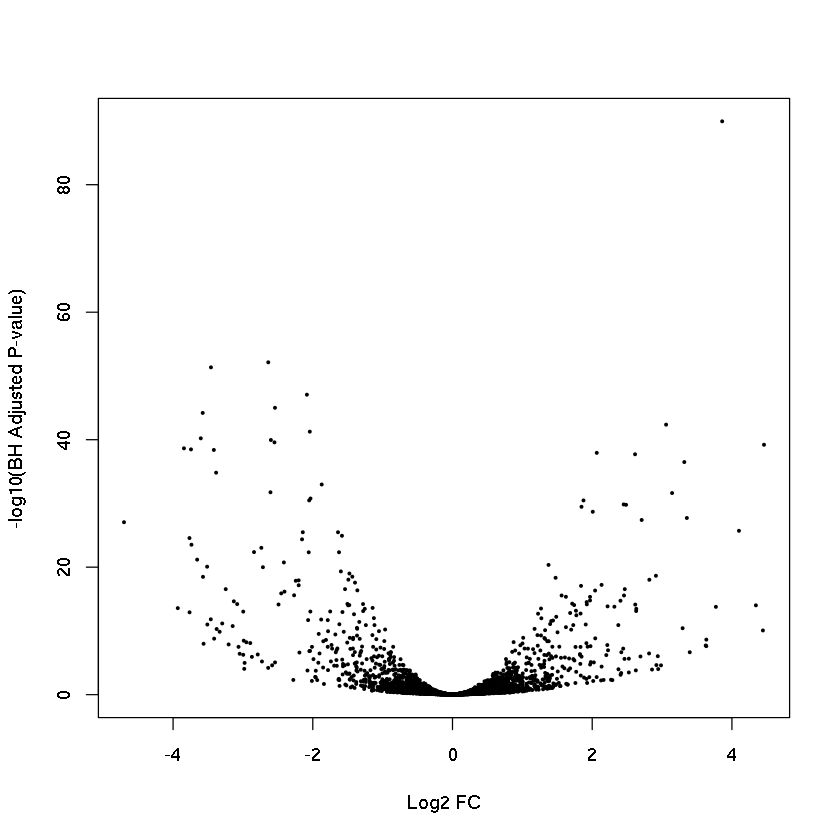

In [31]:
plot(myres$log2FoldChange,-log10(myres$padj),pch=19,cex=0.3,xlab="Log2 FC",ylab="-log10(BH Adjusted P-value)")

Exercise: Annotate the hits with adjusted P-values < 0.05 and absolute log2 FC greater than 2 in red

# Converting/Normalizing Counts to "Expressions" 

## Normalized Counts

We have already shown how to "normalize" the counts using the estimated size factors

In [12]:
head(counts(dds,normalize=TRUE),3)

,AGTCAA,AGTTCC,ATGTCA,CCGTCC,GTCCGC,GTGAAA
GeneID:12930114,125.5584,110.9918,133.3500,136.2424,148.3102,203.1861
GeneID:12930115,31.92163,34.02668,22.37417,20.43636,29.47781,39.70304
GeneID:12930116,15.96082,44.55875,33.11377,55.63231,33.16253,31.52888


Plot the counts stratified by treatment for the 2nd gene

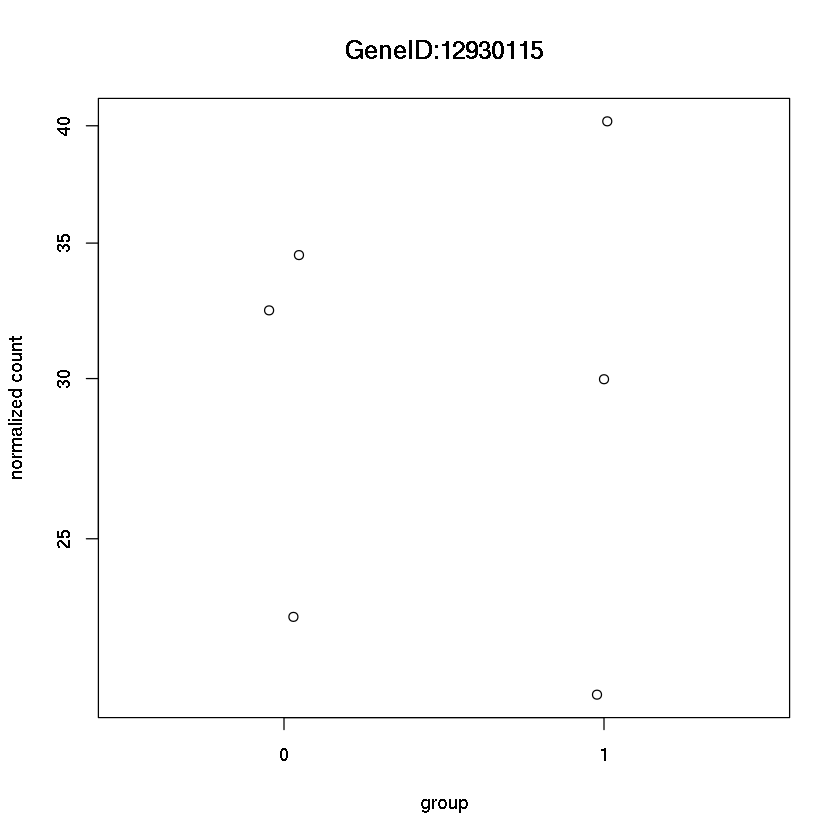

In [34]:
 plotCounts(dds, 2,intgroup="trt")

Or alternatively (better)

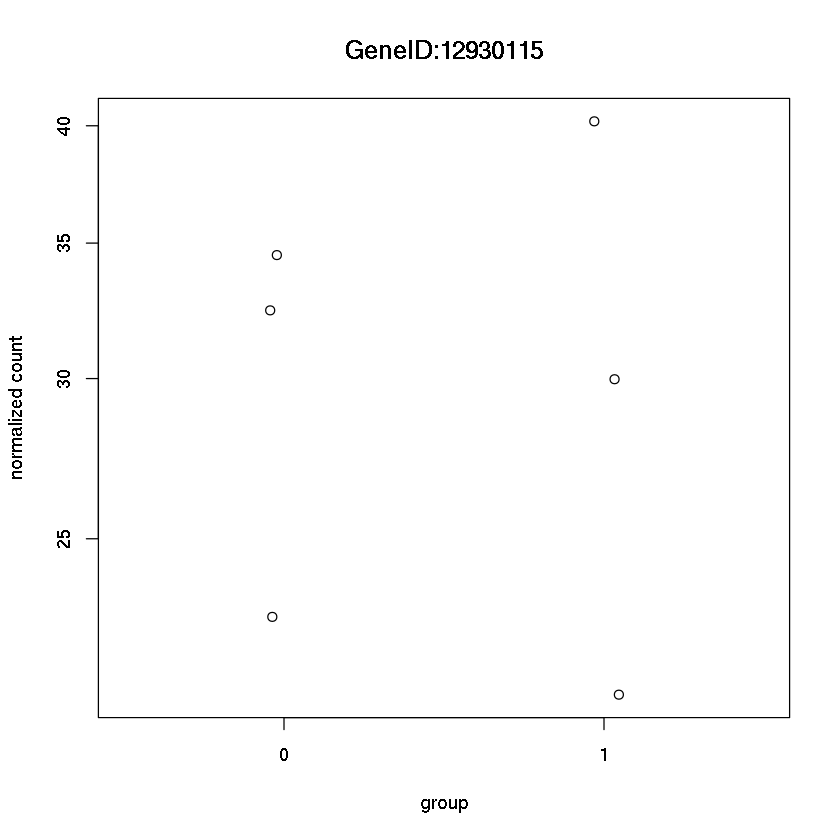

In [35]:
 plotCounts(dds, "GeneID:12930115",intgroup="trt")

Now get this plot for the top hit

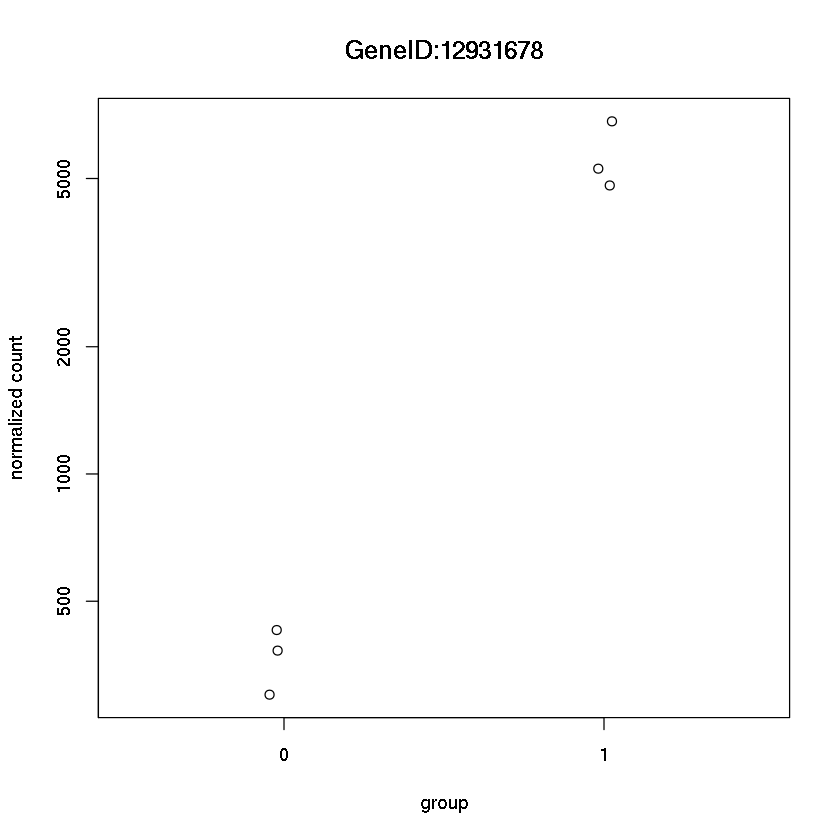

In [36]:
plotCounts(dds, "GeneID:12931678",intgroup="trt")

## FPM

In [ ]:
Another approach is to FPM: fragments per million mapped fragments

In [13]:
head(fpm(dds),3)

,AGTCAA,AGTTCC,ATGTCA,CCGTCC,GTCCGC,GTGAAA
GeneID:12930114,49.01406,43.32771,52.05567,53.18475,57.89565,79.31749
GeneID:12930115,12.461202,13.282948,8.734172,7.977713,11.507209,15.498819
GeneID:12930116,6.230601,17.394336,12.926575,21.717107,12.945610,12.307886


Let's calculate the FPM manually. For gene $i$ sample $j$, the FPM is defined as $\frac{K_{ij}}{D_j}\times 10^{6}$ where $D_j=\sum_{i=1} K_{ij}$ is the read depth for sample $j$. First get the read depth for each sample

In [27]:
D=colSums(counts(dds))
D

AGTCAA  AGTTCC  ATGTCA  CCGTCC  GTCCGC  GTGAAA 
2324804 3199231 3032225 2237181 2662410 2224981

By default, the fpm() function uses a robust approach. We will disable this right now as to replicate the standard FPM. Let's look at gene 1

In [17]:
fpm1=fpm(dds,robust=FALSE)[1,]
fpm1

AGTCAA   AGTTCC   ATGTCA   CCGTCC   GTCCGC   GTGAAA 
50.75697 42.82279 49.13883 53.63893 60.47153 78.20291

Now get the raw counts for gene 1

In [18]:
cnt1=counts(dds)[1,]
cnt1

AGTCAA AGTTCC ATGTCA CCGTCC GTCCGC GTGAAA 
   118    137    149    120    161    174

Now calculate the FPM for gene 1

In [28]:
myfpm1=cnt1/D*1e6
myfpm1

AGTCAA   AGTTCC   ATGTCA   CCGTCC   GTCCGC   GTGAAA 
50.75697 42.82279 49.13883 53.63893 60.47153 78.20291

This is how you check if two numeric columns are "equal"

In [23]:
min(abs(fpm1-myfpm1))

[1] 0

## FPKM

To calculate the FPKM (fragments per kilobase per million mapped fragments) we need to add annotation to assign the feature lengths. More specifically, for gene $i$ sample $j$, the FPKM is defined as $\frac{K_{ij}}{\ell_i D_j}\times 10^3 \times 10^{6}$ where $\ell_i$ is the "length" of gene $i$ (fragments for each $10^3$ bases in the gene for every  $\frac{D_j}{10^6}$ fragments. More on this later.

## Regularized log transformation

The regularized log transform can be obtained using the rlog() function. Note that an important argument for this function is blind (TRUE by default). The default "blinds" the normalization to the design. This is very important so as to not bias the analyses (e.g. class discovery 

In [41]:
rld=rlog(dds,blind=TRUE)

In [ ]:
Hierarchical clustering using rlog transformation

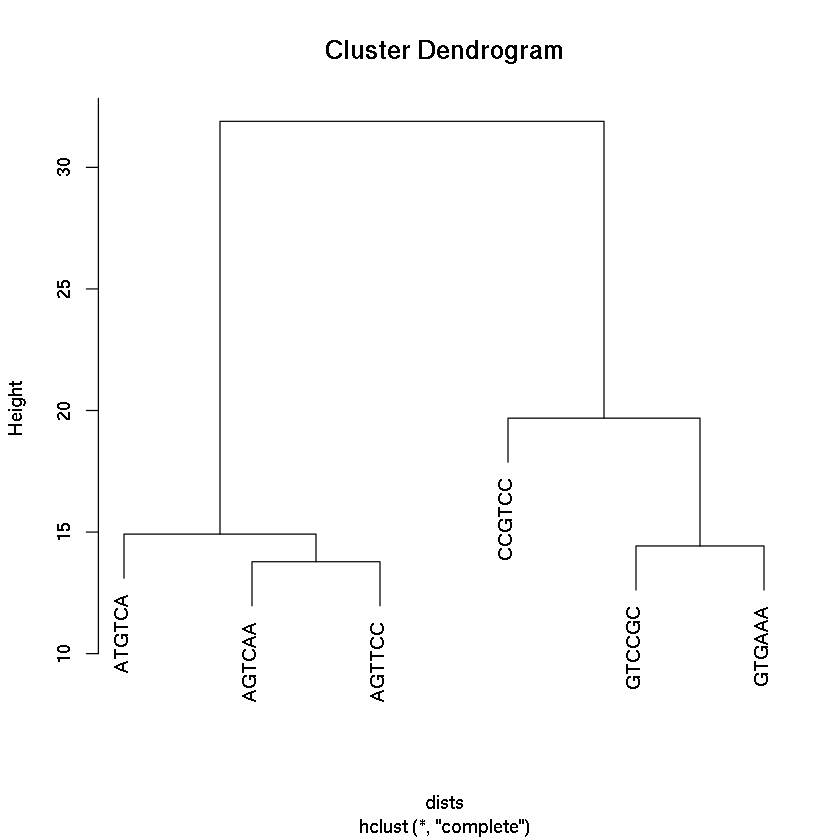

In [42]:
dists=dist(t(assay(rld)))
plot(hclust(dists))


PC Analysis using the rlog transformation

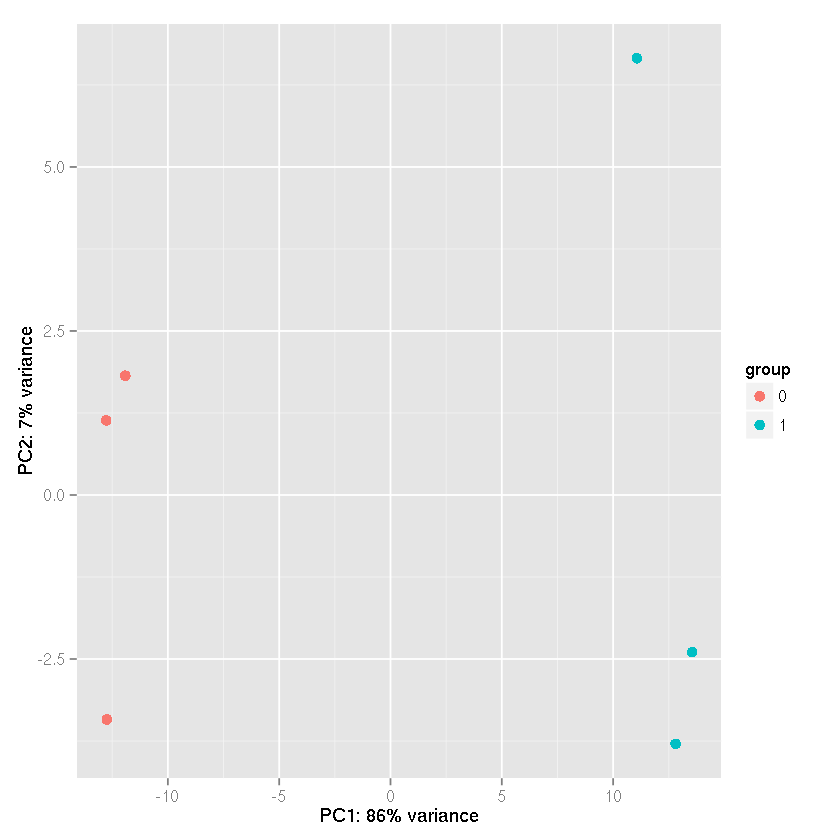

In [48]:
 plotPCA(rld,intgroup="trt")

In [123]:
sessionInfo()

R version 3.2.1 (2015-06-18)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Debian GNU/Linux 8 (jessie)

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C               LC_TIME=en_US.UTF-8       
 [4] LC_COLLATE=en_US.UTF-8     LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                  LC_ADDRESS=C              
[10] LC_TELEPHONE=C             LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] tools     parallel  stats4    stats     graphics  grDevices utils     datasets  methods  
[10] base     

other attached packages:
 [1] MASS_7.3-40               knitr_1.10.5              DESeq2_1.8.1             
 [4] RcppArmadillo_0.5.200.1.0 Rcpp_0.11.6               GenomicRanges_1.20.5     
 [7] GenomeInfoDb_1.4.1        IRanges_2.2.5             S4Vectors_0.6.2          
[10] BiocGenerics_0.14.0      

loaded via a namespace (and not attached):
 [1] genefilter_1.50.0    locfit_1.5-9.1       repr